In [ ]:
# Baixa e extrai o dataset
!mkdir data/
!curl -L -o data/animais.zip "https://drive.google.com/uc?export=download&id=16Lll0Slg1unWxAb26AzZqI9sPdB_fYpV"
!unzip data/animais.zip -d data

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
def train_model(model, trainloader, valloader, criterion, optimizer, device=device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }
    
    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')
        
        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def test_model(model, testloader, device=device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [4]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# data_dir = 'data/hymenoptera_data'
data_dir = "data/animais"

train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

In [5]:
model = models.resnet18()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

100%|██████████| 13/13 [00:34<00:00,  2.63s/it]


Epoch 1, Train Loss: 0.695, Train Accuracy: 54.00%


/home/rsouza/Projects/pos-graduacao/.venv/lib/python3.13/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Val Loss: 0.700, Val Accuracy: 45.08%


100%|██████████| 13/13 [00:35<00:00,  2.75s/it]


Epoch 2, Train Loss: 0.693, Train Accuracy: 51.25%
Epoch 2, Val Loss: 0.681, Val Accuracy: 55.74%


100%|██████████| 13/13 [00:35<00:00,  2.76s/it]


Epoch 3, Train Loss: 0.711, Train Accuracy: 52.00%
Epoch 3, Val Loss: 0.672, Val Accuracy: 56.56%


100%|██████████| 13/13 [00:35<00:00,  2.77s/it]


Epoch 4, Train Loss: 0.685, Train Accuracy: 60.25%
Epoch 4, Val Loss: 0.678, Val Accuracy: 55.74%


100%|██████████| 13/13 [00:35<00:00,  2.75s/it]


Epoch 5, Train Loss: 0.660, Train Accuracy: 64.00%
Epoch 5, Val Loss: 0.698, Val Accuracy: 59.84%
Treinamento concluído


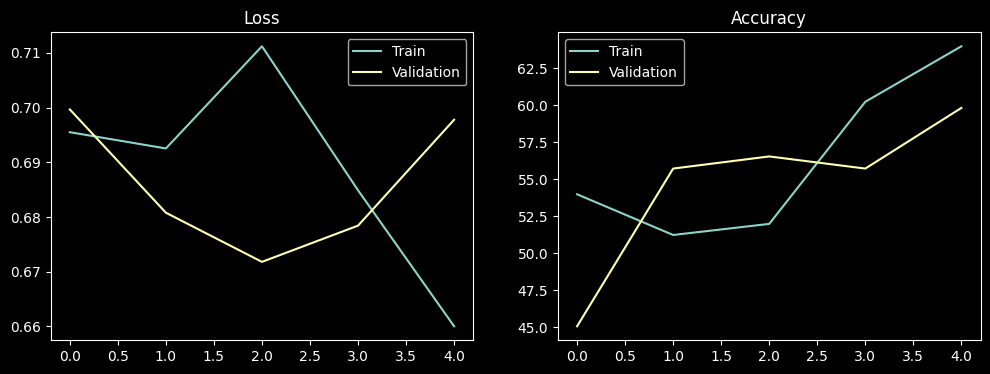

Acurácia da rede na base de teste: 59.84%


In [7]:
# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

plot_history(history)
test_model(model, val_loader)

In [8]:
# Utilizando pesos pré-treinados
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/rsouza/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:02<00:00, 17.6MB/s]


In [9]:
# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False

In [10]:
# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

100%|██████████| 13/13 [00:12<00:00,  1.00it/s]


Epoch 1, Train Loss: 0.659, Train Accuracy: 58.75%
Epoch 1, Val Loss: 0.427, Val Accuracy: 84.43%


100%|██████████| 13/13 [00:13<00:00,  1.02s/it]


Epoch 2, Train Loss: 0.463, Train Accuracy: 80.50%
Epoch 2, Val Loss: 0.254, Val Accuracy: 94.26%


100%|██████████| 13/13 [00:13<00:00,  1.01s/it]


Epoch 3, Train Loss: 0.321, Train Accuracy: 88.75%
Epoch 3, Val Loss: 0.190, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:13<00:00,  1.05s/it]


Epoch 4, Train Loss: 0.298, Train Accuracy: 89.25%
Epoch 4, Val Loss: 0.162, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:13<00:00,  1.02s/it]


Epoch 5, Train Loss: 0.279, Train Accuracy: 89.25%
Epoch 5, Val Loss: 0.143, Val Accuracy: 96.72%
Treinamento concluído


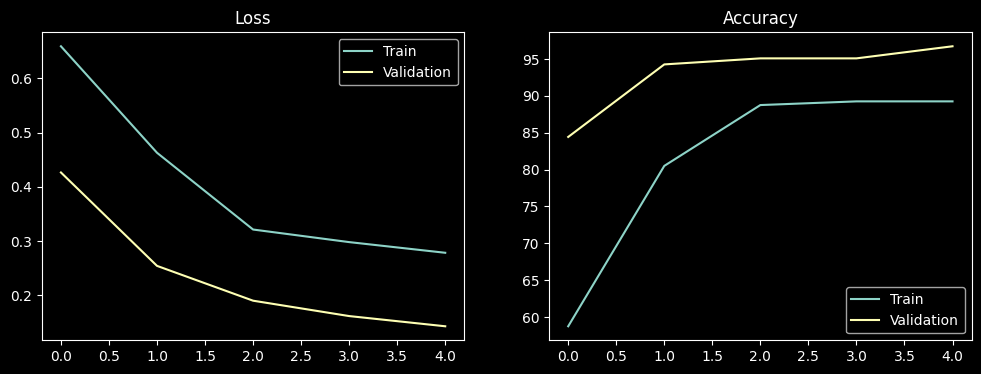

Acurácia da rede na base de teste: 96.72%


In [11]:
# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

plot_history(history)
test_model(model, val_loader)

In [12]:
def plot_and_predict(model, image, class_names, device=device):
    model.eval()
    image = image.to(device)
    outputs = model(image.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
    probs = F.softmax(outputs, dim=1)[0] * 100
    prob = probs[predicted].item()

    # image between 0 and 1
    image = torch.clamp(image * 0.225 + 0.45, 0, 1)
    title = f'Classe: {class_names[predicted]} ({prob:.2f}%)'
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

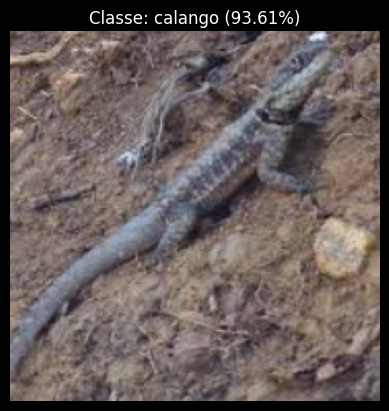

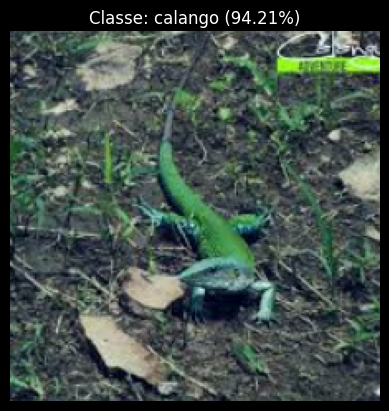

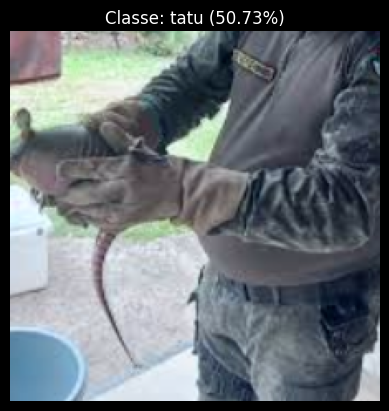

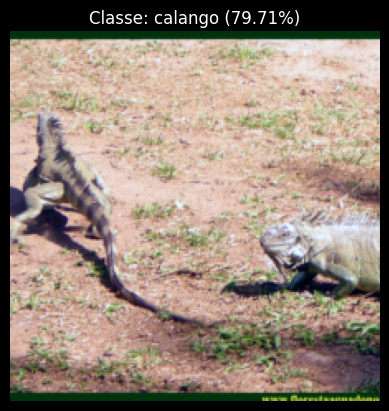

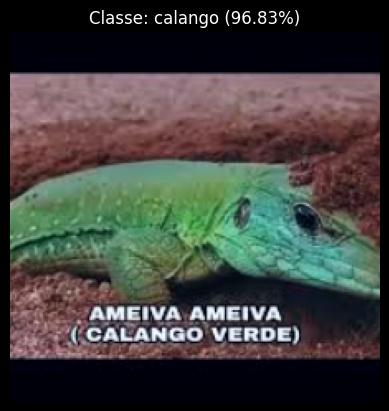

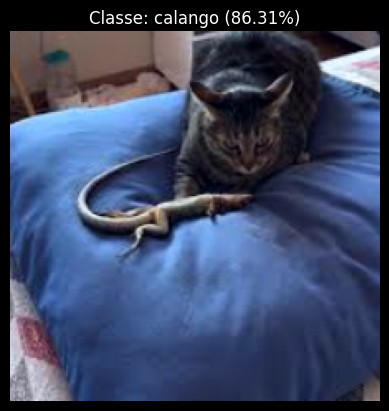

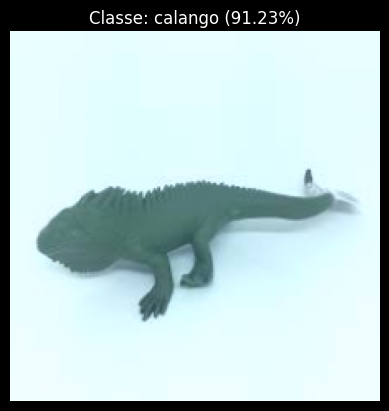

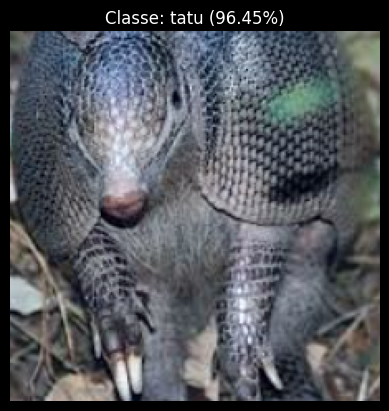

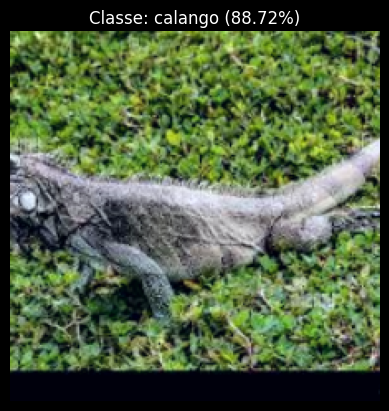

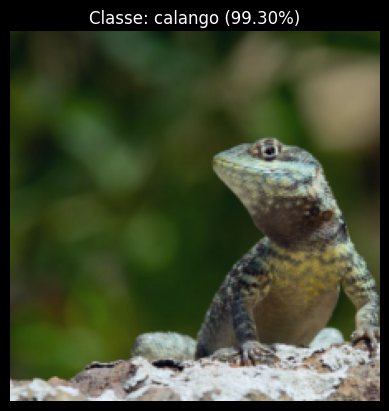

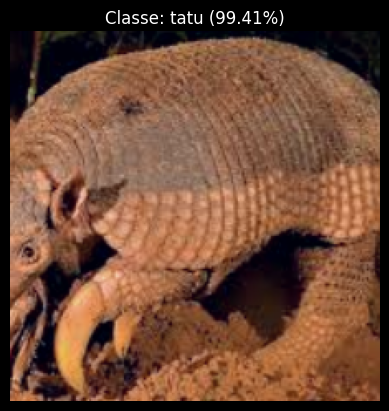

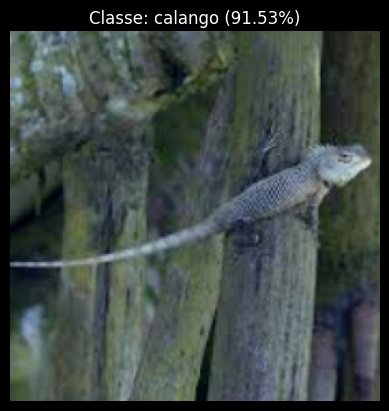

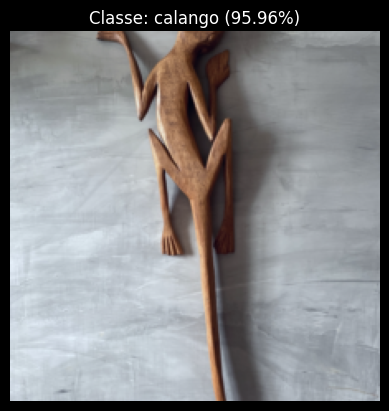

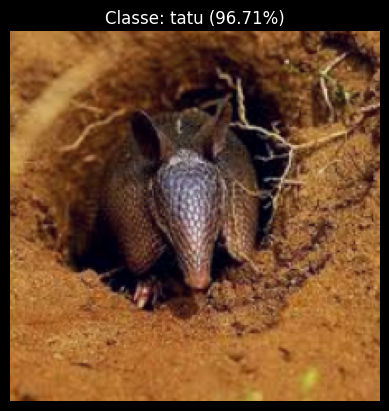

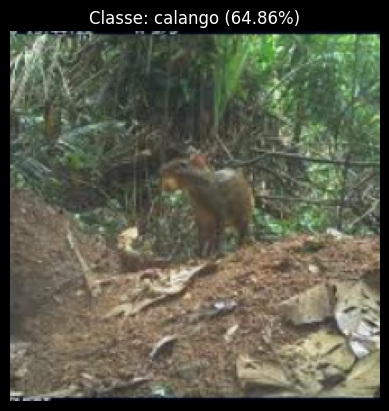

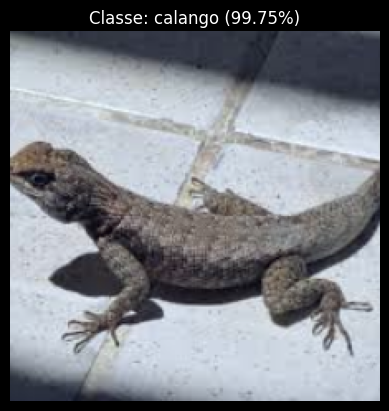

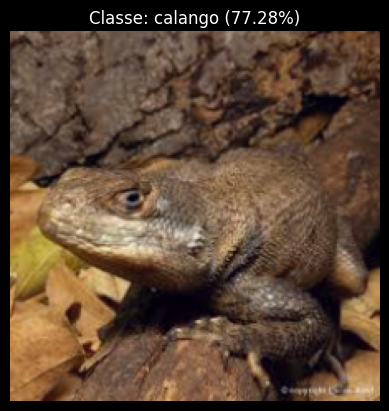

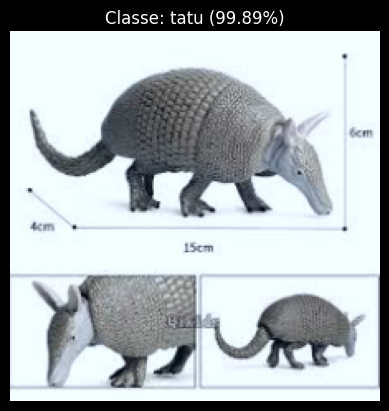

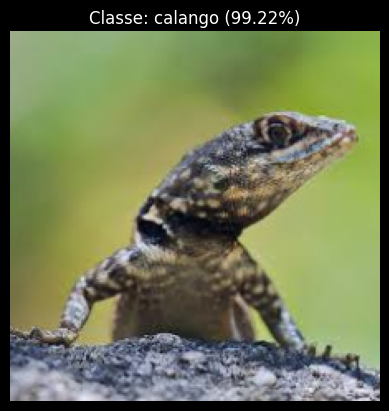

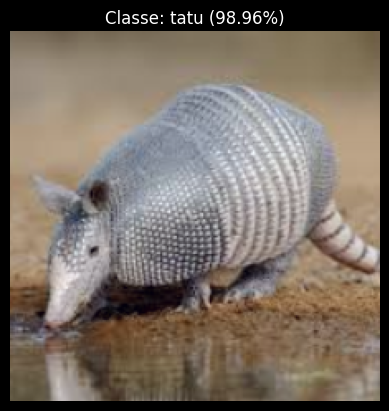

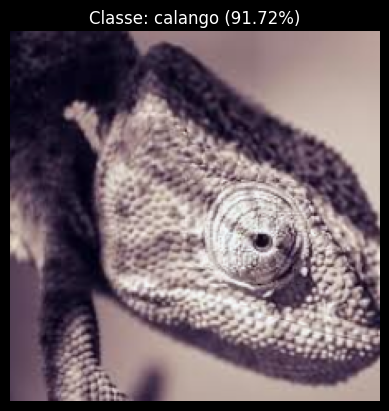

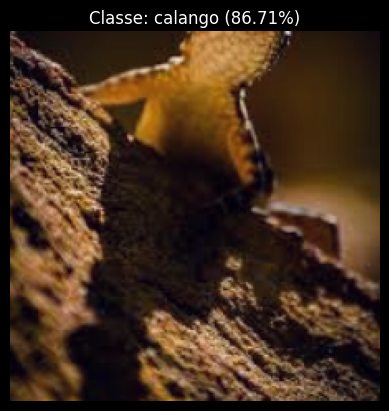

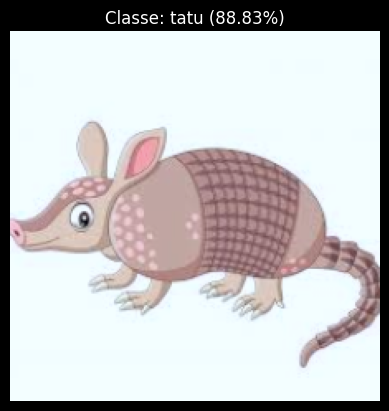

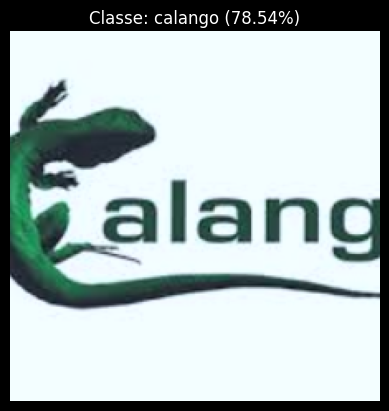

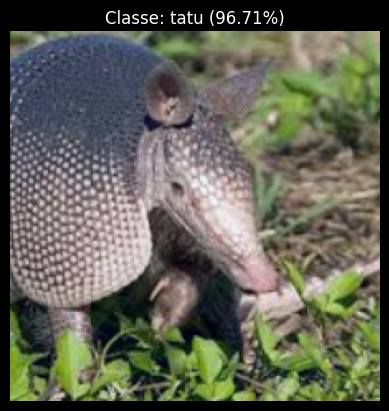

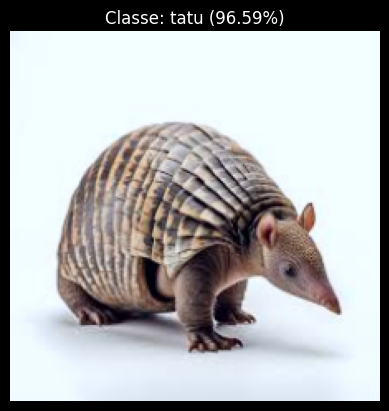

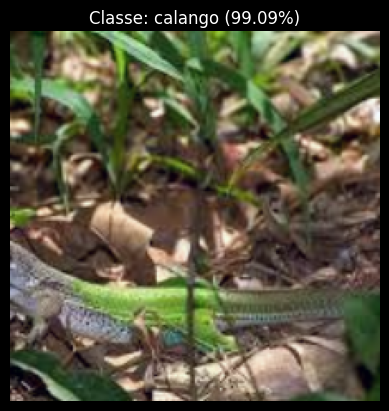

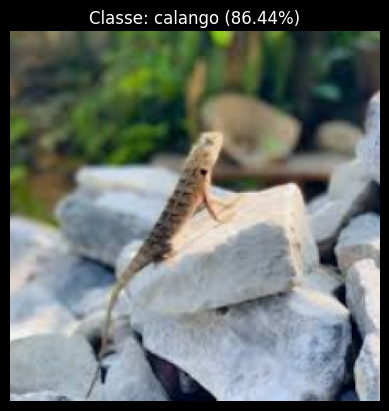

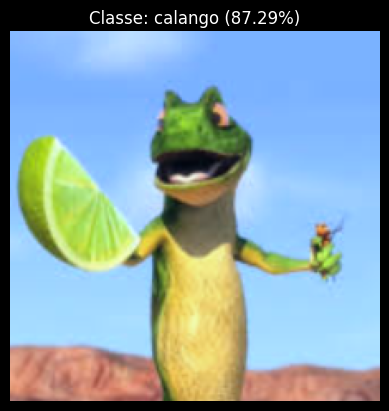

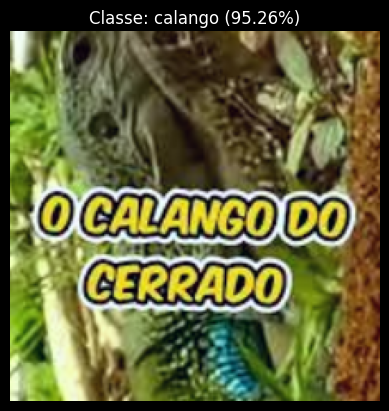

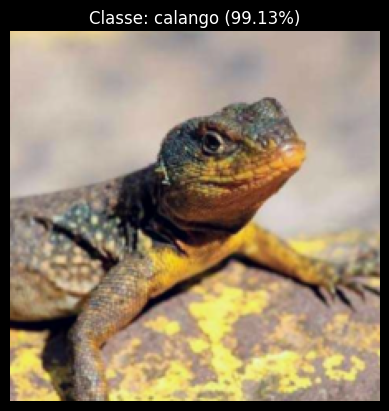

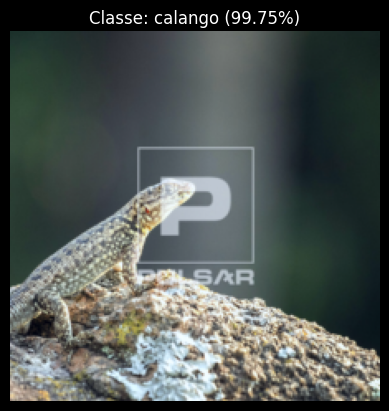

In [13]:
images, labels = next(iter(val_loader))

for image, label in zip(images, labels):
    plot_and_predict(model, image, val_set.classes)

## Exercícios

### Exercício 1
Treine novamente o modelo, mas sem data augmentation. Compare as curvas de treinamento de ambos os casos e comente.

100%|██████████| 13/13 [00:10<00:00,  1.20it/s]


Epoch 1, Train Loss: 0.614, Train Accuracy: 66.75%
Epoch 1, Val Loss: 0.445, Val Accuracy: 81.97%


100%|██████████| 13/13 [00:15<00:00,  1.18s/it]


Epoch 2, Train Loss: 0.333, Train Accuracy: 89.75%
Epoch 2, Val Loss: 0.249, Val Accuracy: 93.44%


100%|██████████| 13/13 [00:16<00:00,  1.25s/it]


Epoch 3, Train Loss: 0.238, Train Accuracy: 92.00%
Epoch 3, Val Loss: 0.276, Val Accuracy: 86.89%


100%|██████████| 13/13 [00:16<00:00,  1.26s/it]


Epoch 4, Train Loss: 0.204, Train Accuracy: 92.75%
Epoch 4, Val Loss: 0.174, Val Accuracy: 95.90%


100%|██████████| 13/13 [00:15<00:00,  1.20s/it]


Epoch 5, Train Loss: 0.205, Train Accuracy: 92.75%
Epoch 5, Val Loss: 0.207, Val Accuracy: 91.80%
Treinamento concluído


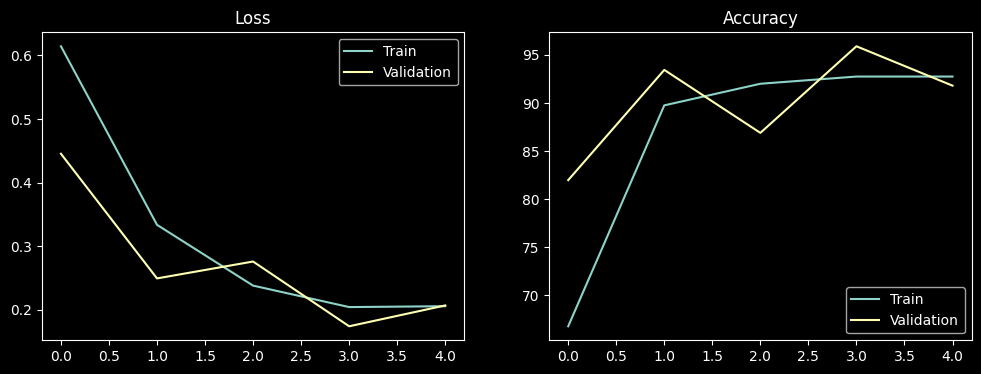

In [14]:
# Recarregando o dataset de treino sem data augmentation
train_set_no_aug = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_no_aug)
train_loader_no_aug = DataLoader(train_set_no_aug, batch_size=32, shuffle=True)

# Recriando o modelo e otimizador (resetando pesos)
model_no_aug = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for param in model_no_aug.parameters():
    param.requires_grad = False
model_no_aug.fc = nn.Linear(model_no_aug.fc.in_features, 2)
model_no_aug = model_no_aug.to(device)

criterion_no_aug = nn.CrossEntropyLoss()
optimizer_no_aug = optim.SGD(model_no_aug.parameters(), lr=0.001, momentum=0.9)

# Treinando o modelo sem data augmentation
history_no_aug = train_model(model_no_aug, train_loader_no_aug, val_loader, criterion_no_aug, optimizer_no_aug, device, num_epochs=5)

# Plotando as curvas de treinamento para comparação
plot_history(history_no_aug)

A comparação dos gráficos mostra o sucesso de um bom treinamento (Gráfico 1) contra um treinamento com overfitting (Gráfico 2).

Gráfico - com data augmentation: Apresenta um modelo estável e que generaliza bem, sem overfitting. A performance na validação é ótima e consistente, provavelmente devido ao uso de Data Augmentation.

Gráfico - sem data augmentation: Mostra um modelo instável. A queda na acurácia e o aumento da perda na validação são sinais claros de overfitting, causado diretamente pela falta de Data Augmentation. O modelo decorou os dados de treino em vez de aprender.

Conclusão: O Modelo 1 é mais confiável. Os gráficos demonstram de forma clara que o uso de Data Augmentation foi o fator decisivo para evitar o overfitting e garantir o sucesso do treinamento.

### Exercício 2
Descongele mais das últimas camadas (à sua escolha), por exemplo `model.layer4[1]`, e treine novamente o modelo.

100%|██████████| 13/13 [00:22<00:00,  1.70s/it]


Epoch 1, Train Loss: 0.282, Train Accuracy: 88.00%
Epoch 1, Val Loss: 0.125, Val Accuracy: 96.72%


100%|██████████| 13/13 [00:21<00:00,  1.62s/it]


Epoch 2, Train Loss: 0.224, Train Accuracy: 93.25%
Epoch 2, Val Loss: 0.133, Val Accuracy: 96.72%


100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


Epoch 3, Train Loss: 0.201, Train Accuracy: 93.50%
Epoch 3, Val Loss: 0.116, Val Accuracy: 97.54%


100%|██████████| 13/13 [00:21<00:00,  1.63s/it]


Epoch 4, Train Loss: 0.218, Train Accuracy: 91.75%
Epoch 4, Val Loss: 0.096, Val Accuracy: 96.72%


100%|██████████| 13/13 [00:20<00:00,  1.60s/it]


Epoch 5, Train Loss: 0.172, Train Accuracy: 95.00%
Epoch 5, Val Loss: 0.098, Val Accuracy: 96.72%
Treinamento concluído


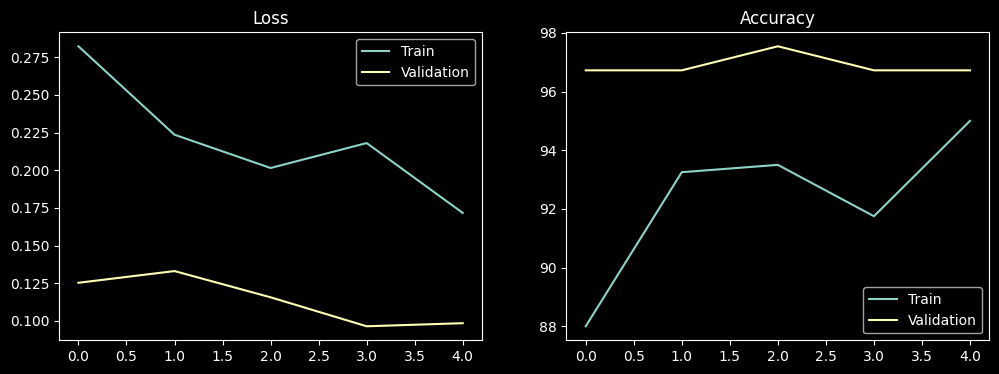

Acurácia da rede na base de teste: 96.72%


In [15]:
# Descongelando as camadas da última camada residual (layer4[1]) e a fully connected (fc)
for param in model.layer4[1].parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# Recrie o otimizador para garantir que apenas os parâmetros descongelados serão atualizados
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)

# Treine novamente o modelo
history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

plot_history(history)
test_model(model, val_loader)

### Exercício 3
Escolha outro modelo pré-treinado dos que foram vistos na aula e substitua no modelo. Lembre-se de alterar a última camada de classificação.

In [16]:
# Substituindo o modelo pelo VGG16 pré-treinado
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Congelar todos os parâmetros
for param in vgg16.parameters():
    param.requires_grad = False

# Substituir a última camada de classificação
num_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_features, 2)
vgg16 = vgg16.to(device)

print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/rsouza/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:57<00:00, 9.64MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

100%|██████████| 13/13 [01:35<00:00,  7.37s/it]


Epoch 1, Train Loss: 0.793, Train Accuracy: 49.00%
Epoch 1, Val Loss: 0.769, Val Accuracy: 44.26%


100%|██████████| 13/13 [01:32<00:00,  7.14s/it]


Epoch 2, Train Loss: 0.778, Train Accuracy: 45.25%
Epoch 2, Val Loss: 0.769, Val Accuracy: 44.26%


100%|██████████| 13/13 [01:36<00:00,  7.41s/it]


Epoch 3, Train Loss: 0.807, Train Accuracy: 42.75%
Epoch 3, Val Loss: 0.765, Val Accuracy: 44.26%


100%|██████████| 13/13 [01:37<00:00,  7.50s/it]


Epoch 4, Train Loss: 0.787, Train Accuracy: 46.00%
Epoch 4, Val Loss: 0.764, Val Accuracy: 44.26%


100%|██████████| 13/13 [01:34<00:00,  7.29s/it]


Epoch 5, Train Loss: 0.827, Train Accuracy: 40.50%
Epoch 5, Val Loss: 0.765, Val Accuracy: 44.26%
Treinamento concluído


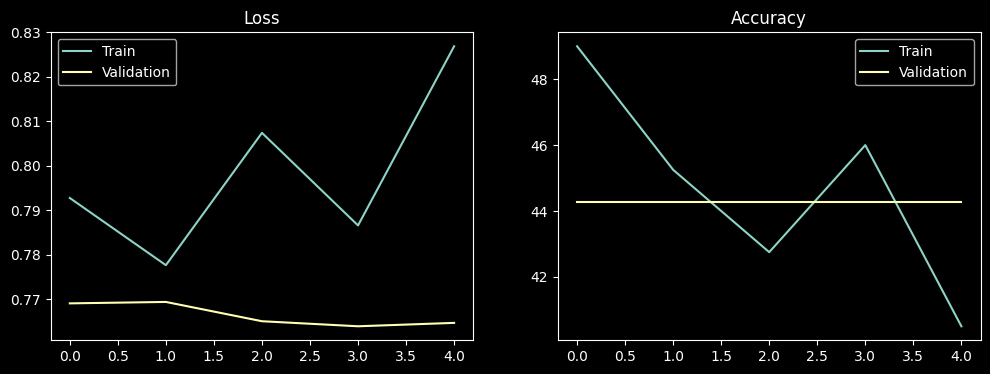

Acurácia da rede na base de teste: 44.26%


In [17]:
# Treine novamente o modelo
history = train_model(vgg16, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

plot_history(history)
test_model(vgg16, val_loader)